# Python Scipt to Split 80/20

In [14]:
import os
import random
import shutil

# Path to the main dataset folder
data_dir = 'brain_tumor_dataset'

# Paths to train and test folder 
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# Create train and test directories if they dont exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# List of class folder
classes = ['yes', 'no']

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)

    random.shuffle(images)

    # Split 80/20
    train_size = int(0.8 * len(images))
    train_images = images[:train_size]
    test_images = images[train_size:]

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move the images to train folder
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))


print("80/20 train-test split completed.")


80/20 train-test split completed.


# Custom dataset 

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Load training dataset
train_dataset = datasets.ImageFolder(root='brain_tumor_dataset/train', transform=data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# Load test dataset
test_dataset = datasets.ImageFolder(root='brain_tumor_dataset/test', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Define Model

In [21]:
import torch.nn as nn
import torch
from torchvision import models

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for 2 classes (binary classification)
num_features = model.fc.in_features  # Get the number of input features to the fully connected layer
model.fc = nn.Linear(num_features, 2)  # Binary classification (yes/no)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/Users/sohanurrahman/Desktop/College/tumor_classification/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sohanurrahman/Desktop/College/tumor_classification/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define Loss function and Optimizer

In [22]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train loop

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_running_loss/len(test_loader)
    val_accuracy = val_correct/val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
   # Print epoch results
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/10, Train Loss: 0.0237, Train Accuracy: 0.9959, Val Loss: 0.0219, Val Accuracy: 1.0000
Epoch 2/10, Train Loss: 0.0492, Train Accuracy: 0.9918, Val Loss: 0.1418, Val Accuracy: 0.9877
Epoch 3/10, Train Loss: 0.1135, Train Accuracy: 0.9631, Val Loss: 1.2099, Val Accuracy: 0.8156
Epoch 4/10, Train Loss: 0.2733, Train Accuracy: 0.8893, Val Loss: 0.8127, Val Accuracy: 0.8934
Epoch 5/10, Train Loss: 0.2379, Train Accuracy: 0.9016, Val Loss: 0.1879, Val Accuracy: 0.9836
Epoch 6/10, Train Loss: 0.1472, Train Accuracy: 0.9508, Val Loss: 0.2017, Val Accuracy: 0.9795
Epoch 7/10, Train Loss: 0.1408, Train Accuracy: 0.9508, Val Loss: 0.1166, Val Accuracy: 0.9918
Epoch 8/10, Train Loss: 0.0504, Train Accuracy: 0.9836, Val Loss: 0.0279, Val Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.0230, Train Accuracy: 0.9918, Val Loss: 0.0232, Val Accuracy: 1.0000
Epoch 10/10, Train Loss: 0.0369, Train Accuracy: 0.9836, Val Loss: 0.0454, Val Accuracy: 0.9918


# Plot the metrices

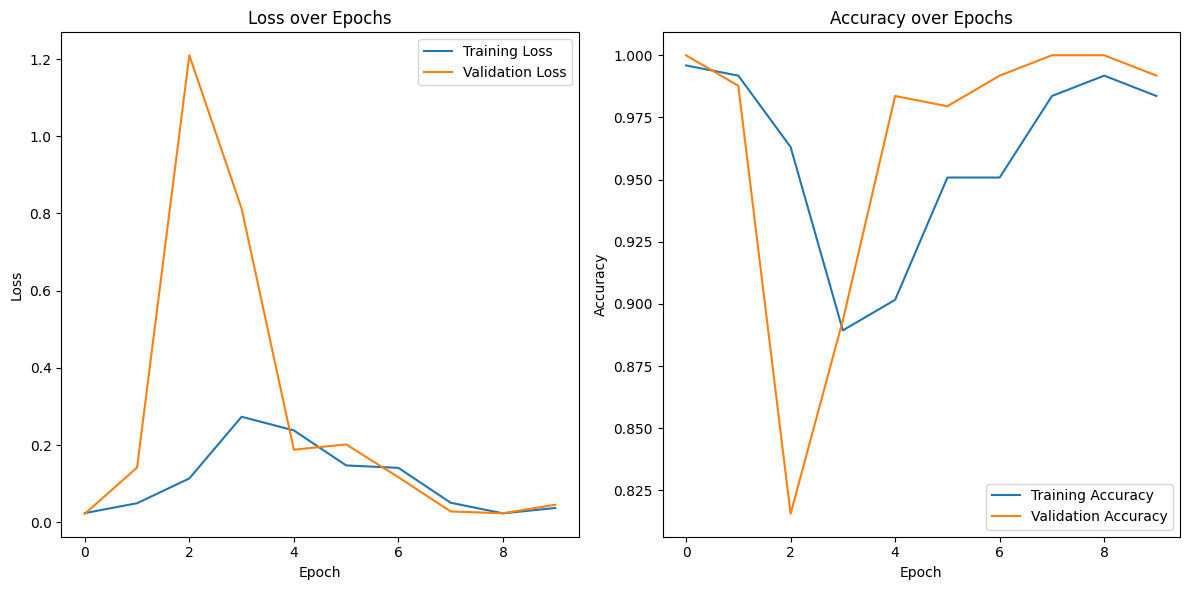

In [40]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Save the model

In [41]:
torch.save(model.state_dict(), 'resnet50_binary.pth')

# Test with a images

/var/folders/6n/_3v7211x5hj3mg4qs5wn4yph0000gn/T/ipykernel_89669/3369202438.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_b

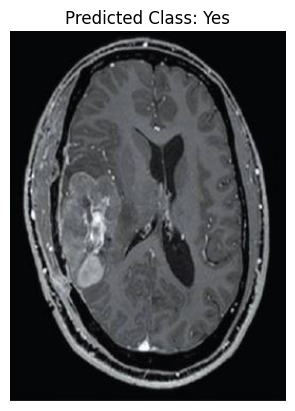

In [44]:
from PIL import Image
import torchvision.transforms as transforms

def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def predict_image(model, image_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor.to(device))  # Move to GPU if necessary
        _, predicted = torch.max(output, 1)
    return predicted.item()  # Return the class index

import matplotlib.pyplot as plt

def display_prediction(image_path, prediction):
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.title(f'Predicted Class: {"NO" if prediction == 0 else "Yes"}')
    plt.axis('off')  # Hide axes
    plt.show()


# Load your trained model
model.load_state_dict(torch.load('resnet50_binary.pth'))
model.to(device)

# Path to the image you want to test
image_path = 'yes/Y193.jpg'

# Load and preprocess the image
image_tensor = load_and_preprocess_image(image_path)

# Make prediction
prediction = predict_image(model, image_tensor)

# Display the image and prediction
display_prediction(image_path, prediction)
